# Emotion Analysis using SVM and K-Means Clustering
### Task Category: Text Classification 
### Approach: Suport Vector Machines and K-Means Clustering
### Dataset: Emotion Lines

In [471]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import cluster
from sklearn.decomposition import PCA

## Data Loading and Preprocessing

### Data Loading and Parsing

#### Understanding the dataset
1. The dataset available is in json format and is already split into 3 sets: train, validation and test
2. Each row is list of json object and corresponds back and forth dialogs between speakers for a perticular scene
3. Each json object contains 4 attributes: speaker, utterance, emotion and annotation.

In [48]:
train_path = 'data/friends_train.json'
val_path = 'data/friends_dev.json'
test_path = 'data/friends_test.json'

In [240]:
ds = pd.read_json(train_path)
ds.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,"{'speaker': 'Chandler', 'utterance': 'also I w...","{'speaker': 'The Interviewer', 'utterance': 'Y...","{'speaker': 'Chandler', 'utterance': 'That I d...","{'speaker': 'The Interviewer', 'utterance': 'S...","{'speaker': 'Chandler', 'utterance': 'My dutie...","{'speaker': 'The Interviewer', 'utterance': 'N...","{'speaker': 'Chandler', 'utterance': 'I see.',...","{'speaker': 'The Interviewer', 'utterance': 'B...","{'speaker': 'Chandler', 'utterance': 'Good to ...","{'speaker': 'The Interviewer', 'utterance': 'W...",...,"{'speaker': 'Joey', 'utterance': 'But then who...","{'speaker': 'Rachel', 'utterance': 'You know? ...","{'speaker': 'Joey', 'utterance': 'No-no-no-no,...","{'speaker': 'Rachel', 'utterance': 'No, I-I-I-...","{'speaker': 'Joey', 'utterance': 'Ok!', 'emoti...","{'speaker': 'Joey', 'utterance': 'All right, w...","{'speaker': 'Joey', 'utterance': 'I'm gonna se...","{'speaker': 'Joey', 'utterance': 'I'll see you...","{'speaker': 'Rachel', 'utterance': 'Yeah, sure...",None
1,"{'speaker': 'Chandler', 'utterance': 'Hey, Mon...","{'speaker': 'Monica', 'utterance': 'Hey-hey-he...","{'speaker': 'Chandler', 'utterance': 'Do I eve...","{'speaker': 'Monica', 'utterance': 'Chris says...","{'speaker': 'Chandler', 'utterance': 'No way!'...","{'speaker': 'Monica', 'utterance': 'Yeah, appa...","{'speaker': 'Chandler', 'utterance': 'Just cof...","{'speaker': 'Monica', 'utterance': 'Got me.', ...","{'speaker': 'Chandler', 'utterance': 'Can I ge...","{'speaker': 'Monica', 'utterance': 'Hey, did y...",...,"{'speaker': 'Chandler', 'utterance': 'What, wh...","{'speaker': 'Phoebe', 'utterance': 'What?!', '...","{'speaker': 'Phoebe', 'utterance': 'He was wit...","{'speaker': 'Phoebe', 'utterance': 'Look, 'My...","{'speaker': 'Phoebe', 'utterance': 'Now that I...","{'speaker': 'Phoebe', 'utterance': 'He thinks ...","{'speaker': 'Chandler', 'utterance': 'You real...","{'speaker': 'Phoebe', 'utterance': 'Oh, totall...","{'speaker': 'Joey', 'utterance': 'Done.', 'emo...",None
2,"{'speaker': 'Rachel', 'utterance': 'Hey!', 'em...","{'speaker': 'Ross', 'utterance': 'Hi!', 'emoti...","{'speaker': 'Rachel', 'utterance': 'What are y...","{'speaker': 'Ross', 'utterance': 'Ah y'know, t...","{'speaker': 'Rachel', 'utterance': 'Oh.', 'emo...","{'speaker': 'Ross', 'utterance': 'Hi.', 'emoti...","{'speaker': 'Rachel', 'utterance': 'Hi.', 'emo...","{'speaker': 'Ross', 'utterance': 'Howd did it...","{'speaker': 'Rachel', 'utterance': 'Oh well, t...","{'speaker': 'Ross', 'utterance': 'Im so proud...",...,"{'speaker': 'Rachel', 'utterance': 'Yeah.', 'e...","{'speaker': 'Phoebe', 'utterance': 'Ameri-can....","{'speaker': 'Sergei', 'utterance': 'Ameri-ccan...","{'speaker': 'Phoebe', 'utterance': 'Ameri-can....","{'speaker': 'Sergei', 'utterance': 'Everybody!...",None,None,None,None,None
3,"{'speaker': 'Chandler', 'utterance': 'Good job...","{'speaker': 'Joey', 'utterance': 'You liked it...","{'speaker': 'Chandler', 'utterance': 'Oh-ho-ho...","{'speaker': 'Joey', 'utterance': 'Which part e...","{'speaker': 'Chandler', 'utterance': 'The whol...","{'speaker': 'Joey', 'utterance': 'Oh no-no-no,...","{'speaker': 'Chandler', 'utterance': 'I love t...","{'speaker': 'Joey', 'utterance': 'Hey, what ab...","{'speaker': 'Chandler', 'utterance': 'I was su...","{'speaker': 'Joey', 'utterance': 'You fell asl...",...,"{'speaker': 'Chandler', 'utterance': 'Dont go...","{'speaker': 'Chandler', 'utterance': 'Im sorr...","{'speaker': 'Chandler', 'utterance': 'Im so s...","{'speaker': 'Chandler', 'utterance': 'Look!', ...","{'speaker': 'Chandler', 'utterance': 'This guy...","{'speaker': 'Chandler', 'utterance': 'He fell ...","{'speaker': 'Chandler', 'utterance': 'Be mad a...","{'speaker': 'Chandler', 'utterance': 'Or, call...",None,None
4,"{'speaker': 'Joey', 'utterance': 'Okay, look, ...","{'speaker': 'Ross', 'utterance': 'What?! What ...","{'speaker': 'Phoebe', 'utterance': 'Yes, and i...","{'speaker': 'Phoebe', 'utt

4. As it can be seen above that there are 24 columns which means the maximum number of dialog in a scene is 24.
5. Some lists do not have all columns populated and also the utterance in few dialogs have unrecognized character.

#### Dataset Parsing

1. Since the dataset we have is mostly unstructured and difficult to manipulate for training and testing we parse the dataset
2. We create a function create_dialog_dataset(path) which reads the dataset into a dataframe and transforms each dialog into a single row with 4 columns 'speaker', 'utterance', 'emotion', 'annotation'
3. Since the 'utterance' contains unrecognized characters we use .encode('ascii', 'ignore').decode() to remove those from the text

In [49]:
def create_dialog_dataset(path):
    data = pd.read_json(path)
    new_ds = pd.DataFrame(columns=['speaker', 'utterance', 'emotion', 'annotation'])
    dialogs = 0
    nones = 0
    for row_num in range(len(data)):
        for col_num in range(len(data.iloc[row_num])):
            # print(row_num, col_num)
            dialog = data.iloc[row_num][col_num]
            if dialog == None:
                nones = nones + 1
            else:
                temp = {'speaker': dialog['speaker'],
                        'utterance':dialog['utterance'].encode('ascii', 'ignore').decode(),
                        'emotion':dialog['emotion'],
                        'annotation':dialog['annotation']}
                
                new_ds = new_ds._append(temp, ignore_index = True)
                dialogs = dialogs +1
    print('Number of Dialogs:', dialogs)
    return new_ds

In [149]:
train_data = create_dialog_dataset(train_path)
val_data = create_dialog_dataset(val_path)
test_data = create_dialog_dataset(test_path)

Number of Dialogs: 10561
Number of Dialogs: 1178
Number of Dialogs: 2764


In [150]:
train_data

,speaker,utterance,emotion,annotation
0,Chandler,also I was the point person on my companys tra...,neutral,4100000
1,The Interviewer,You mustve had your hands full.,neutral,5000000
2,Chandler,That I did. That I did.,neutral,5000000
3,The Interviewer,So lets talk a little bit about your duties.,neutral,5000000
4,Chandler,My duties? All right.,surprise,2000030
...,...,...,...,...
10556,Chandler,You or me?,neutral,3000011
10557,Ross,"I got it. Uh, Joey, women don't have Adam's ap...",non-neutral,2100011
10558,Joey,"You guys are messing with me, right?",surprise,0000050
10559,All,Yeah.,neutral,4000010


#### Combining datasets
1. We currently have 3 datasets which have to be preprocessed and converted into numeric representation
2. If we preprocess the text of these 3 separetly then we get three distinct set of features which conflits with the trained model output and the prediction on validation and test set
3. Therefore we first combine the three dataset into one before preprocessing

In [151]:
train_data = train_data._append(val_data, ignore_index = True)
train_data = train_data._append(test_data, ignore_index = True)

In [152]:
train_data

,speaker,utterance,emotion,annotation
0,Chandler,also I was the point person on my companys tra...,neutral,4100000
1,The Interviewer,You mustve had your hands full.,neutral,5000000
2,Chandler,That I did. That I did.,neutral,5000000
3,The Interviewer,So lets talk a little bit about your duties.,neutral,5000000
4,Chandler,My duties? All right.,surprise,2000030
...,...,...,...,...
14498,Phoebe,"Hey, why dont you guys go get portraits done b...",neutral,5000000
14499,Monica,Thats a good idea! I bet they have one of thos...,joy,1400000
14500,Phoebe,"Yeah thats great! Next to that, Chandler wont ...",neutral,3100100
14501,Monica,Chandler what do you say?,neutral,5000000


### Text Preprocessing
1. Our primary input is the utterance column and target variable is emotion.
2. To remove noise and variance from dataset we have to preprocess them.
3. We create a function called preprocess_text(text) that uses NLTK library to perform tokenization, removal of stopwords and lemmatization of the text.
4. We can also use stemming instead of lemmatization, but stemming just removes last few characters of a word but lemmatization ensures that the tokens are actually converted into the base form.

In [154]:
def preprocess_text(text):

    # using nltk.word_tokenize to tokenize the data
    tokens = word_tokenize(text)

    # using stopwords dataset from nltk to filter out stop words from tokenized list
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

    # reducing tokens to base form using nltk.WordNetLemmatizer()
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [wordnet_lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Recreate sentance by joining the lemmatized_tokens
    preprocessed_text = ' '.join(lemmatized_tokens)
    
    return preprocessed_text    

In [157]:
train_data['preprocessed_utterance'] = train_data['utterance'].apply(preprocess_text)
train_data.head()

,speaker,utterance,emotion,annotation,preprocessed_utterance
0,Chandler,also I was the point person on my companys tra...,neutral,4100000,also point person company transition KL-5 GR-6...
1,The Interviewer,You mustve had your hands full.,neutral,5000000,mustve hand full .
2,Chandler,That I did. That I did.,neutral,5000000,. .
3,The Interviewer,So lets talk a little bit about your duties.,neutral,5000000,let talk little bit duty .
4,Chandler,My duties? All right.,surprise,2000030,duty ? right .


In [159]:
print('Before Preprocessing:',train_data['utterance'][1])
print('After Preprocessing:',train_data['preprocessed_utterance'][1])

Before Preprocessing: You mustve had your hands full.
After Preprocessing: mustve hand full .


### Converting to numeric representation
1. Once our data is preprocesed we have to convert it into the numeric representation to make it uniform and structured.
2. SKlear's TF-ID Vectorizer helps convert the dataset into TF-IDF vectors which is basically transforming raw text into a more suitable format for analysis and modeling.
3. This helps the models to focus on the meaningful and relevant information in the text and improve their efficiency and effectiveness

In [160]:
# Converting preprocessed data to numerical representation using SKlearn's TF-ID Vectorizer
# Initializing Vectorizer
vectorizer = TfidfVectorizer()
# Fitting the vectorizer to the preprocessed_utterance column and transforming them into TF-IDF vectors
tfidf_matrix = vectorizer.fit_transform(train_data['preprocessed_utterance'])

# Extracting Feature names
feature_names = vectorizer.get_feature_names_out()

# Converting to pandas data frame of dense array
tfidf_data = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)    
    

In [245]:
tfidf_data.describe()

,00,000,10,100,11,110,112,12,1200,123go,...,zelners,zero,zillionaire,zine,zinfandel,zip,zone,zoo,zuchoff,zygomatic
count,14503.000000,14503.000000,14503.000000,14503.000000,14503.000000,14503.000000,14503.000000,14503.000000,14503.000000,14503.000000,...,14503.000000,14503.000000,14503.000000,14503.000000,14503.000000,14503.000000,14503.000000,14503.000000,14503.000000,14503.000000
mean,0.000296,0.000242,0.000301,0.000100,0.000025,0.000035,0.000035,0.000037,0.000026,0.000046,...,0.000031,0.000032,0.000058,0.000032,0.000035,0.000020,0.000044,0.000151,0.000031,0.000024
std,0.015479,0.011966,0.012062,0.007130,0.002996,0.004178,0.004178,0.004515,0.003131,0.005560,...,0.003722,0.003909,0.006929,0.003888,0.004193,0.002394,0.003783,0.009444,0.003781,0.002888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,0.693486,0.633857,0.360814,0.503128,0.503128,0.543748,0.377069,0.669638,...,0.448234,0.470735,0.834463,0.468219,0.504901,0.288314,0.336407,0.774687,0.455333,0.347799


### Test Train Split
1. After preprocessing the text data and converting it into TF-IDF vectors we split the dataset
2. passing the 'emotion' column as target variable and entire vectorised dataset as inputs we split the dataset into three
3. The train: test: val ratio here is 70:20:10

In [398]:
X_train,  X_test, y_train, y_test = train_test_split(tfidf_data, 
                                                    train_data['emotion'], 
                                                    test_size=0.2, 
                                                    random_state=42)

In [168]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                    y_train, 
                                                    test_size=0.1, 
                                                    random_state=42)

### Class distribution of target variable in Train set

In [182]:
y_train.value_counts()

emotion
neutral        4688
non-neutral    1976
joy            1251
surprise       1193
anger           543
sadness         363
disgust         235
fear            192
Name: count, dtype: int64

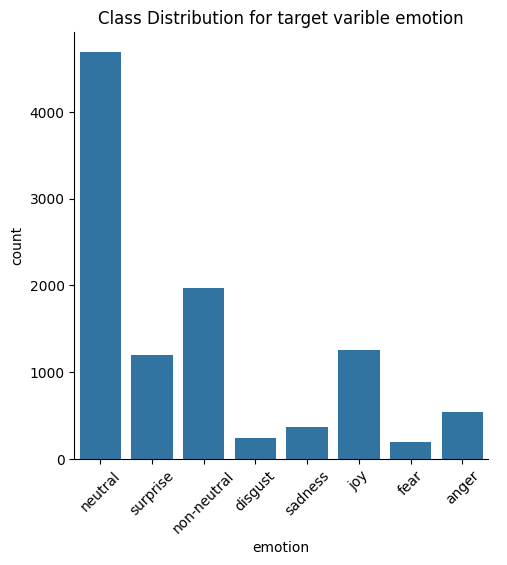

In [178]:
emotion_distribution = sns.catplot(x = 'emotion', kind = 'count', data = pd.DataFrame(y_train))
emotion_distribution.set(title='Class Distribution for target varible emotion')
plt.xticks(rotation=45)
plt.show()

### SVM for Emotion Classification

#### Using LinearSVC()
1. We first create an instance of the LinearSVC class from SKLearn.
2. We use cross_val_score to fit the model to the train data using a K-fold cross validation method where K=4

In [293]:
# Training a Linear Support Vector machine using LinearSVC class on the training data
LinearSVC_classifier = LinearSVC(dual = 'auto')

# LinearSVC_classifier.fit(X_train, y_train)

# using K fold cross validation to fit the LinearSVC for K=4
LinearSVC_cv_scores = cross_val_score(LinearSVC_classifier, X_train, y_train, cv=4, scoring = 'accuracy')

LinearSVC_classifier.fit(X_train, y_train)

LinearSVC(dual='auto')

train time < 1 second

In [294]:
mean_cv_score = LinearSVC_cv_scores.mean()
std_cv_score = LinearSVC_cv_scores.std()
print("Mean cross-validation accuracy:", mean_cv_score)
print("Standard deviation of cross-validation accuracy:", std_cv_score)

Mean cross-validation accuracy: 0.4734223099735718
Standard deviation of cross-validation accuracy: 0.003696543228663302


Validation Report for LinearSVC trains using K-fold Cross validation:
              precision    recall  f1-score   support

       anger       0.29      0.17      0.21        71
     disgust       0.17      0.08      0.11        26
        fear       0.00      0.00      0.00        11
         joy       0.35      0.28      0.31       131
     neutral       0.54      0.75      0.63       532
 non-neutral       0.28      0.19      0.23       221
     sadness       0.19      0.10      0.13        41
    surprise       0.40      0.30      0.35       128

    accuracy                           0.46      1161
   macro avg       0.28      0.23      0.25      1161
weighted avg       0.41      0.46      0.42      1161



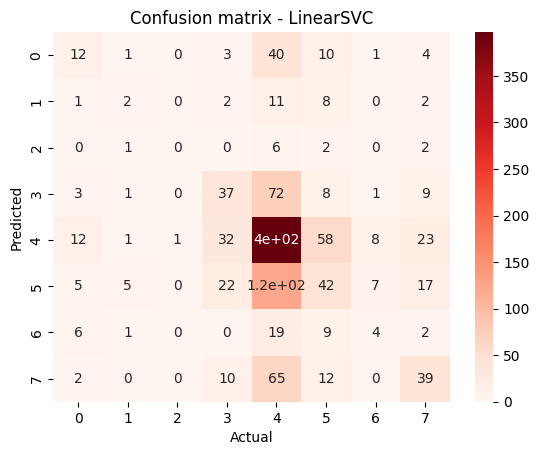

In [477]:
y_pred_val_1 = LinearSVC_classifier.predict(X_val)
print("Validation Report for LinearSVC trains using K-fold Cross validation:")
print(classification_report(y_val, y_pred_val_1))

cm = confusion_matrix(y_val, y_pred_val_1)
plt.title('Confusion matrix - LinearSVC')
ax = sns.heatmap(cm, cmap = 'Reds', annot = True)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

#### Optimize the classifier using rbf kernel

In [473]:
SVC_rbf_classifier = SVC(kernel='rbf', C=1.0, gamma='auto', random_state = 1)
SVC_rbf_classifier.fit(X_train, y_train)

SVC(gamma='auto', random_state=1)

Validation Report for Radial Kernel SVC:
              precision    recall  f1-score   support

       anger       0.80      0.06      0.11        71
     disgust       0.00      0.00      0.00        26
        fear       0.00      0.00      0.00        11
         joy       0.46      0.13      0.20       131
     neutral       0.48      0.95      0.64       532
 non-neutral       0.32      0.05      0.08       221
     sadness       0.29      0.05      0.08        41
    surprise       0.61      0.15      0.24       128

    accuracy                           0.48      1161
   macro avg       0.37      0.17      0.17      1161
weighted avg       0.46      0.48      0.37      1161



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

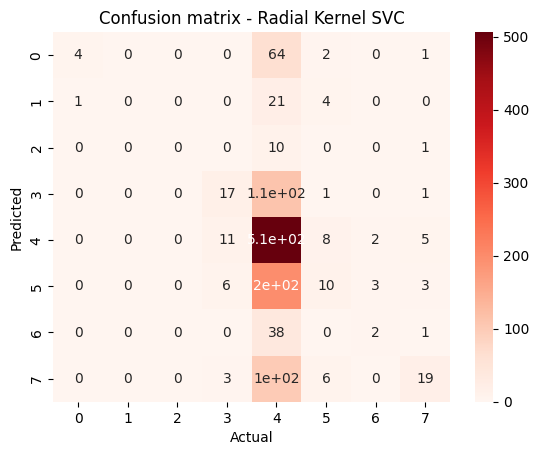

In [478]:
y_pred_val_rbf = SVC_poly_classifier.predict(X_val)
print("Validation Report for Radial Kernel SVC:")
print(classification_report(y_val, y_pred_val_rbf))

cm = confusion_matrix(y_val, y_pred_val_rbf)
plt.title('Confusion matrix - Radial Kernel SVC')
ax = sns.heatmap(cm, cmap = 'Reds', annot = True)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

#### Optimize the classifier using poly kernel

In [299]:
SVC_poly_classifier = SVC(kernel='poly', C=1.0, degree = 2)
# using K fold cross validation to fit the Polynomial kernel SVM for K=4
SVC_poly_classifier.fit(X_train, y_train)
# PolySVC_cv_scores = cross_val_score(SVC_poly_classifier, X_train, y_train, cv=4, scoring = 'accuracy')

SVC(degree=4, kernel='poly')

train time: 653 seconds

Validation Report for Polynomial Kernel SVC:
              precision    recall  f1-score   support

       anger       0.80      0.06      0.11        71
     disgust       0.00      0.00      0.00        26
        fear       0.00      0.00      0.00        11
         joy       0.46      0.13      0.20       131
     neutral       0.48      0.95      0.64       532
 non-neutral       0.32      0.05      0.08       221
     sadness       0.29      0.05      0.08        41
    surprise       0.61      0.15      0.24       128

    accuracy                           0.48      1161
   macro avg       0.37      0.17      0.17      1161
weighted avg       0.46      0.48      0.37      1161



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

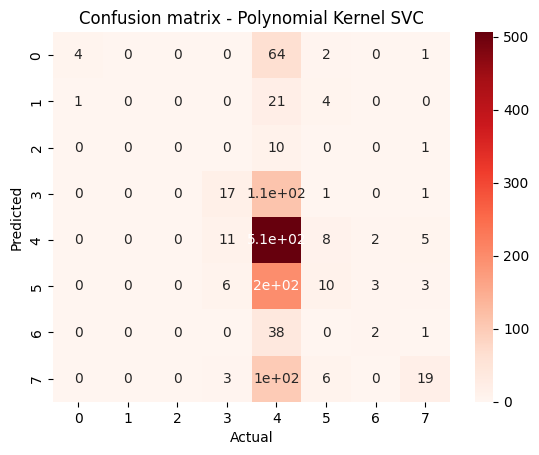

In [474]:
y_pred_val_2 = SVC_poly_classifier.predict(X_val)
print("Validation Report for Polynomial Kernel SVC:")
print(classification_report(y_val, y_pred_val_2))

cm = confusion_matrix(y_val, y_pred_val_2)
plt.title('Confusion matrix - Polynomial Kernel SVC')
ax = sns.heatmap(cm, cmap = 'Reds', annot = True)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

### K-Means Clustering

#### Implement K-Means clustering on the preprocessed text data

1. We use the KMeans class from the SKLearn.Cluster to implement K-Means clustering
2. We start with k=2 and till k=7 to search the optimal k value
3. Hyperparameters are set as follows:
   * n_clusters = 2 to 7
   * init = 'k-means++' (the cluster centroids will be initially assigned using sampling instead of randomly)
   * tol = 0.0004 (Relative tolerance for convergence)
   * random_state = 1 (random seed for centroid generation)
   * n_init = 10 (the algorithm runs 10 times with random centroid seed)
   * algorithm = 'elkan' (more efficient version of Naive K Means algorithm)

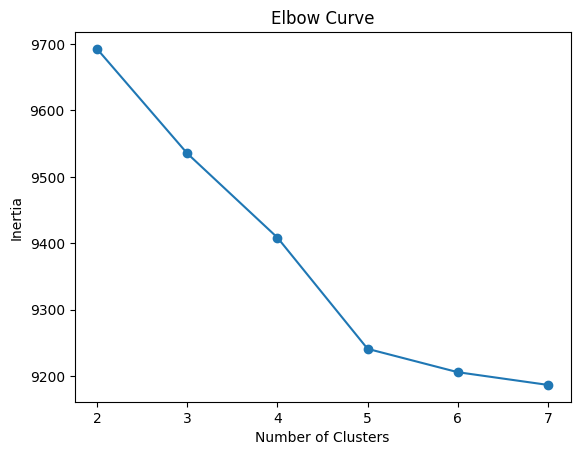

In [379]:
# Initializing a range of cluster sizes
min_clusters = 2
max_clusters = 7
inertia_values = []  # Store inertia values for each number of clusters

for n in range(min_clusters, max_clusters + 1):
    # Initialize K-Means with current number of clusters
    kmeans = cluster.KMeans(n_clusters=n
                            , init = 'k-means++'
                            , tol = 0.0001
                            , random_state = 1
                            , n_init = 10
                            , algorithm = 'elkan')
    
    # Fitting K-Means to the preprocessed TF-IDF data
    kmeans.fit(X_train)
    
    # Calculate inertia (within-cluster sum of squares)
    inertia_values.append(kmeans.inertia_)
    
# Plotting the elbow curve to visualize the inertia values
plt.plot(range(min_clusters, max_clusters + 1), inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.xticks(range(min_clusters, max_clusters + 1))
plt.show()

#### Identify the optimal number of clusters

1. Looking at the elbow of the curve we can consider 5 clusters to be the optimal k value
2. We use k=5 and the previous hyper parameters for the actual KMeans and fit the model on preprocessed data

In [400]:
optimal_num_clusters = 5

# Re-fit K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_num_clusters
                , init = 'k-means++'
                , tol = 0.0001
                , random_state = 1
                , n_init = 10
                , algorithm = 'elkan')
kmeans.fit(X_train)

# Get cluster assignments
cluster_labels_train = kmeans.predict(X_train)
cluster_labels_test = kmeans.predict(X_test)

#### Interpreting clusters and patterns
1. The Kmeans predicts the cluster based on the X_train which is then mapped to the respective emotion from y_train
2. The data frame obtained from this mapping can then be used to convert the results into cluster based emotion counts

In [401]:
cluster_emotion_train = pd.DataFrame({'Cluster': cluster_labels_train, 'Emotion': y_train})
cluster_emotion_test = pd.DataFrame({'Cluster': cluster_labels_test, 'Emotion': y_test})

In [402]:
cluster_emotion_train

,Cluster,Emotion
5687,0,neutral
3616,0,non-neutral
9624,0,non-neutral
14285,0,non-neutral
12746,0,non-neutral
...,...,...
5191,0,joy
13418,0,disgust
5390,0,joy
860,0,anger


In [404]:
# Analyze the distribution of emotions within each cluster for training data
cluster_emotion_counts_train = cluster_emotion_train.groupby(['Cluster', 'Emotion']).size().unstack(fill_value=0)
print("Emotion Distribution within Clusters for Training Data:")
print(cluster_emotion_counts_train)


# Analyze the distribution of emotions within each cluster for test data
cluster_emotion_counts_test = cluster_emotion_test.groupby(['Cluster', 'Emotion']).size().unstack(fill_value=0)
print("\n\nEmotion Distribution within Clusters for Testing Data:")
print(cluster_emotion_counts_test)

Emotion Distribution within Clusters for Training Data:
Emotion  anger  disgust  fear   joy  neutral  non-neutral  sadness  surprise
Cluster                                                                     
0          574      241   177  1092     4433         1958      374      1080
1            8        3     9    67      323           52        6        10
2           21       15    17    79      148          105       19       196
3            6        2     0    53      206           35        5        14
4            5        0     0    91      110           47        0        21


Emotion Distribution within Clusters for Testing Data:
Emotion  anger  disgust  fear  joy  neutral  non-neutral  sadness  surprise
Cluster                                                                    
0          139       62    41  264     1129          514       84       268
1            4        1     1   18       75           14        0         4
2            1        6     1   16       27 

##### Emotions by Cluster
1. For each of the 5 cluster we a barplot depicting the count of each emotion
2. since the dataset was largely skewed and imbalanced the 'neutral' and 'non-neutral' class dominate the results

Emotion distribution across clusters on test data


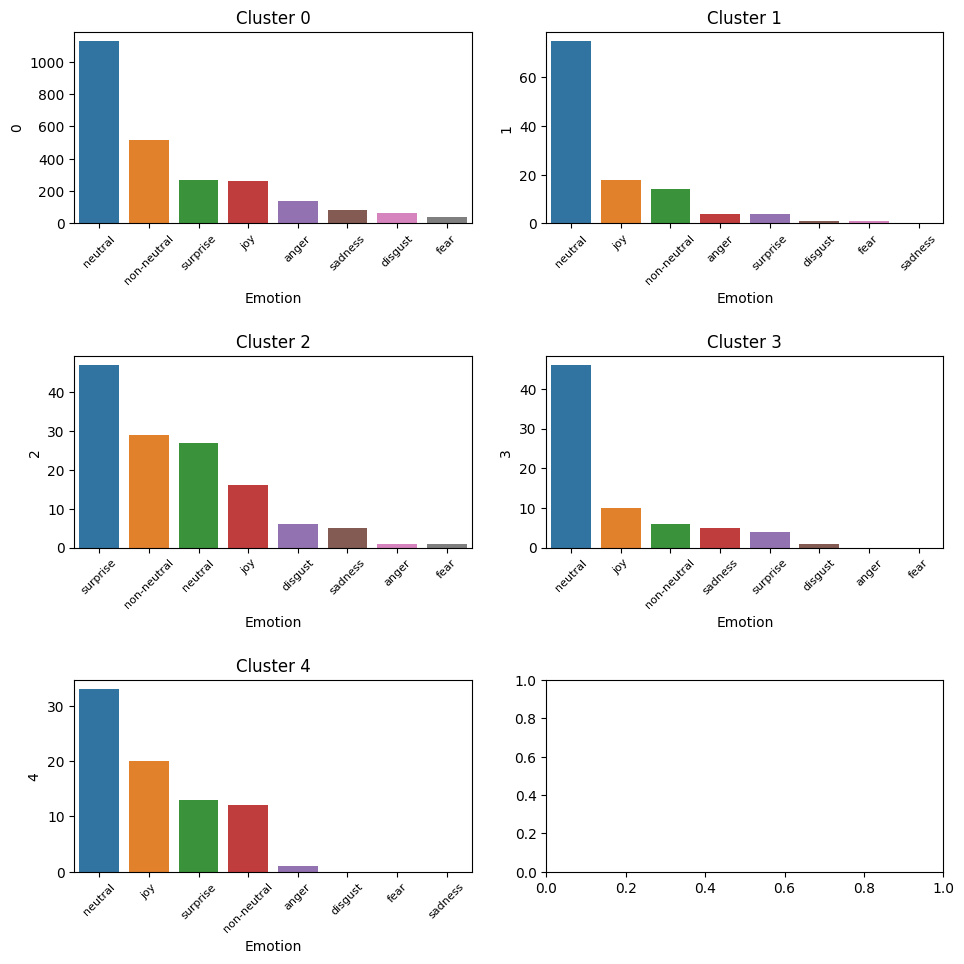

In [481]:
print('Emotion distribution across clusters on test data')
fig, positions = plt.subplots(3, 2, figsize=(10,10))
y = 0
for val in range(0,5):
    i, j = divmod(y, 2)
    data = pd.DataFrame(cluster_emotion_counts_test.iloc[y].sort_values(ascending=False))
    sns.barplot(x = 'Emotion'
                 , y = y
                 , orient = 'v'
                 , hue='Emotion' 
                 , data = data
                 , ax = positions[i, j])
    
    # positions[i, j].set_xticklabels(positions[i, j].get_xticklabels(), rotation=45, ha='right')
    positions[i, j].tick_params(axis='x', rotation=45, labelsize=8)
    
    # Set plot title
    positions[i, j].set_title(f'Cluster {y}')
    y = y + 1
fig.tight_layout(pad = 2.0)

##### PCA to visualize clusters
1. When reduced to 2 dimensions we can see the clusters very clearly.
2. In a lower dimension the separation between clusters appears to be radial

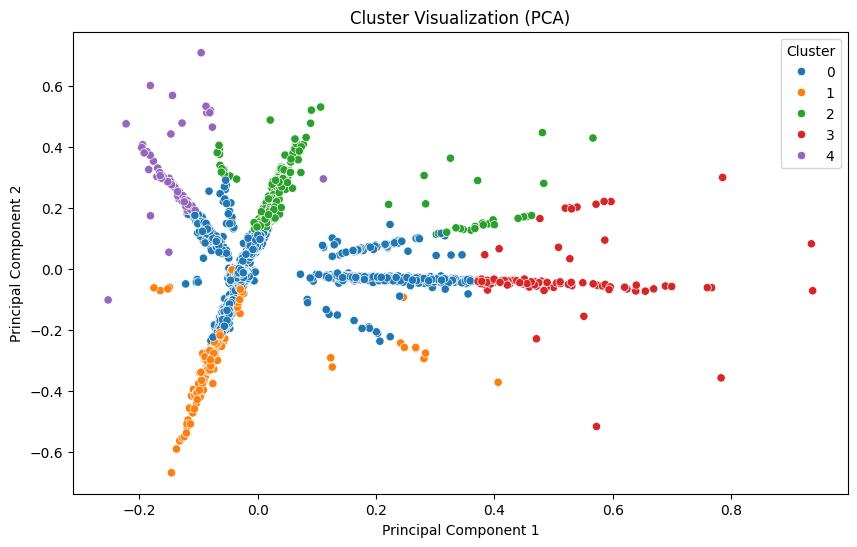

In [483]:
# Reduce dimensionality of TF-IDF matrix for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
# Plot clusters in 2D space
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels_train, palette='tab10', legend='full')
plt.title('Cluster Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()